In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medulloblastoma-cavalli-parsed/GSE85217_Cavalli_subgroups_information_parsed.csv
/kaggle/input/medulloblastoma-cavalli-parsed/palettecolors.py
/kaggle/input/medulloblastoma-cavalli-parsed/parser.py
/kaggle/input/medulloblastoma-cavalli-parsed/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_parsed.txt/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_parsed.txt


# GSE85217 medulloblastoma Cavalli - UMAP projection

## Import lib and datas

In [2]:
# lib import
import numpy as np
import pandas as pd
import os
from collections import OrderedDict
import math
#import functools

import matplotlib.pyplot as plt
import seaborn as sns


import cuml
import cupy as cp
from cuml.manifold import UMAP

In [3]:
def check_path_file(path,file):
    assert os.path.exists(os.path.join(path,file)), f"{file} file not found !"    

In [4]:
check_path_file(path='/kaggle/input/medulloblastoma-cavalli-parsed/',file='parser.py')
check_path_file(path='/kaggle/input/medulloblastoma-cavalli-parsed/',file='palettecolors.py')

import sys
sys.path.insert(1,'/kaggle/input/medulloblastoma-cavalli-parsed/')

from parser import Data

In [5]:
path_exp_mat='/kaggle/input/medulloblastoma-cavalli-parsed/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_parsed.txt/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_parsed.txt'
path_meta='/kaggle/input/medulloblastoma-cavalli-parsed/GSE85217_Cavalli_subgroups_information_parsed.csv'

In [6]:
# Palettes
pal_subgroup={'WNT':'royalblue',
             'SHH':'crimson',
             'Group3':'gold',
             'Group4':'forestgreen'}

pal_subtype={'WNT_alpha':'royalblue',
             'WNT_beta':'lightskyblue',
             'SHH_alpha':'crimson',
             'SHH_beta':'peru',
             'SHH_gamma':'orchid',
             'SHH_delta':'lightpink',
             'Group3_alpha':'gold',
             'Group3_beta':'khaki',
             'Group3_gamma':'orange',
             'Group4_gamma':'forestgreen',
             'Group4_beta':'palegreen',
             'Group4_alpha':'springgreen'}

In [7]:
data=Data()
data.add_exp_mat(path_exp_mat,index_col="genes_name")
data.add_meta(path_meta=path_meta,index_col="samples_name")

In [8]:
import itertools

class DimReduction():
    
    def __init__(self,mat_embedded:pd.DataFrame=None,metadata:pd.DataFrame=None,palette:dict=None,clusters:list=None):
        self.mat_embedded=mat_embedded
        self.metadata=metadata
        self.palette=palette
        self.clusters=clusters
        
    def add_mat_embedded(self,mat_embedded:pd.DataFrame):
        
        if mat_embedded.shape[1]!=2:
            raise ValueError("Matrix embedded dimensions is not equal to 2 !")
        
        self.mat_embedded=mat_embedded
    
    def add_metadata(self,metadata):
        self.metadata=metadata
    
    def add_palette(self,palette):
        self.palette=palette
    
    def add_clusters(self,col_clusters:str,metadata:pd.DataFrame=None):
        
        if metadata is None:
            metadata=self.metadata
            
        if col_clusters in metadata.columns:
            self.clusters=metadata[col_clusters]
        else:
            raise ValueError(f"{col_clusters} is not in metadata columns names")
    
    @staticmethod
    def check_index(mat1:pd.DataFrame,mat2:pd.DataFrame) -> pd.DataFrame:
        
        index_mat1=mat1.index.to_list()
        index_mat2=mat2.index.to_list()
        
        if len(set(index_mat2).difference(set(index_mat1)))!=0:
            raise ValueError("The index do not match!")
        
        mat1=mat1.loc[index_mat2,]
        
        return mat1
        
    def compute_umap_model_2D(self,exp_mat:pd.DataFrame,inplace:bool=True,**kwargs):
        
        # kwargs set default value
        kwargs.setdefault('n_neighbors',15)
        kwargs.setdefault('random_state',42)
        kwargs.setdefault('min_dist',0.5)
        
        kwargs.pop('n_components',None)
        
        # initialize UMAP model from cuML
        umap_model = UMAP(n_components=2,**kwargs)
        mat_embedded=umap_model.fit_transform(exp_mat)
            
        if inplace :
            self.mat_embedded=mat_embedded
        else:
            return mat_embedded
    
    @staticmethod
    def subplot_umap(ax:list=None,mat_embedded:pd.DataFrame=None,palette:dict=None,clusters:list=None,title:str="",**kwargs):
        
        sns.scatterplot(data=mat_embedded, x=mat_embedded[0], y=mat_embedded[1], hue=clusters, palette=palette, ax=ax, **kwargs)
        ax.set_title(title)
    
    def plot_umap_parms(self,parms:dict=None,exp_mat:pd.DataFrame=None,metadata:pd.DataFrame=None,clusters:list=None,col_clusters:list=None,\
                        palette:dict=None,size_subplot:tuple=(5,5),max_cols:int=3,main_title:str="",y_main_title=1.02,**kwargs):
        
        if parms is None:
            raise ValueError("Add parameters dictionnary")
              
        if metadata is None :
            if self.metadata is None:
                raise ValueError("Add metadata samples x features")
            else:
                metadata = self.metadata
        
        exp_mat=self.check_index(mat1=exp_mat,mat2=metadata)
        
        if clusters is None and col_clusters is not None:
            clusters=metadata[col_clusters]
        elif clusters is None and self.clusters is not None:
            clusters = self.clusters
        else:
            raise ValueError("Add clusters vector or columname cluster in metadata")
            
        if palette is None:
            if self.palette is not None:
                palette=self.palette 
            else:
                raise ValueError("Add palette")
                
        n_plots=len(parms)
        
        # create grid
        n_cols = min(max_cols, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols

        figsize= (size_subplot[0] * n_cols, size_subplot[1] * n_rows)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
        axes = axes.flatten() if n_plots > 1 else [axes]
        
        fig.suptitle(main_title, fontsize=12, y=1.02)
        
        for i in range(n_plots):
            if i >= len(axes):
                break
            
            kwargs_parms=parms[i]
            mat_embedded = self.compute_umap_model_2D(exp_mat=exp_mat,inplace=False,**kwargs_parms)

            subplot_title= ",".join(f"{key}={value}" for key, value in kwargs_parms.items())
            self.subplot_umap(ax=axes[i],mat_embedded=mat_embedded,palette=palette,clusters=clusters,title=subplot_title,**kwargs)
            
        plt.show()

In [9]:
def generator_parms(parms:dict):
    parms_vector=[list(value) for value in parms.values()]
    for pv in itertools.combinations(parms_vector,2):
        for p in itertools.product(*pv): #explain this
            yield p

In [10]:
parms_dict = {
    'min_dist': [0.0, 0.1, 0.25, 0.5, 0.8, 0.99],
    'n_neighbors': [5,10,15,25]
}

parms_gen=generator_parms(parms_dict)
parms_list=[dict(zip(parms_dict.keys(),parms_set)) for parms_set in parms_gen]

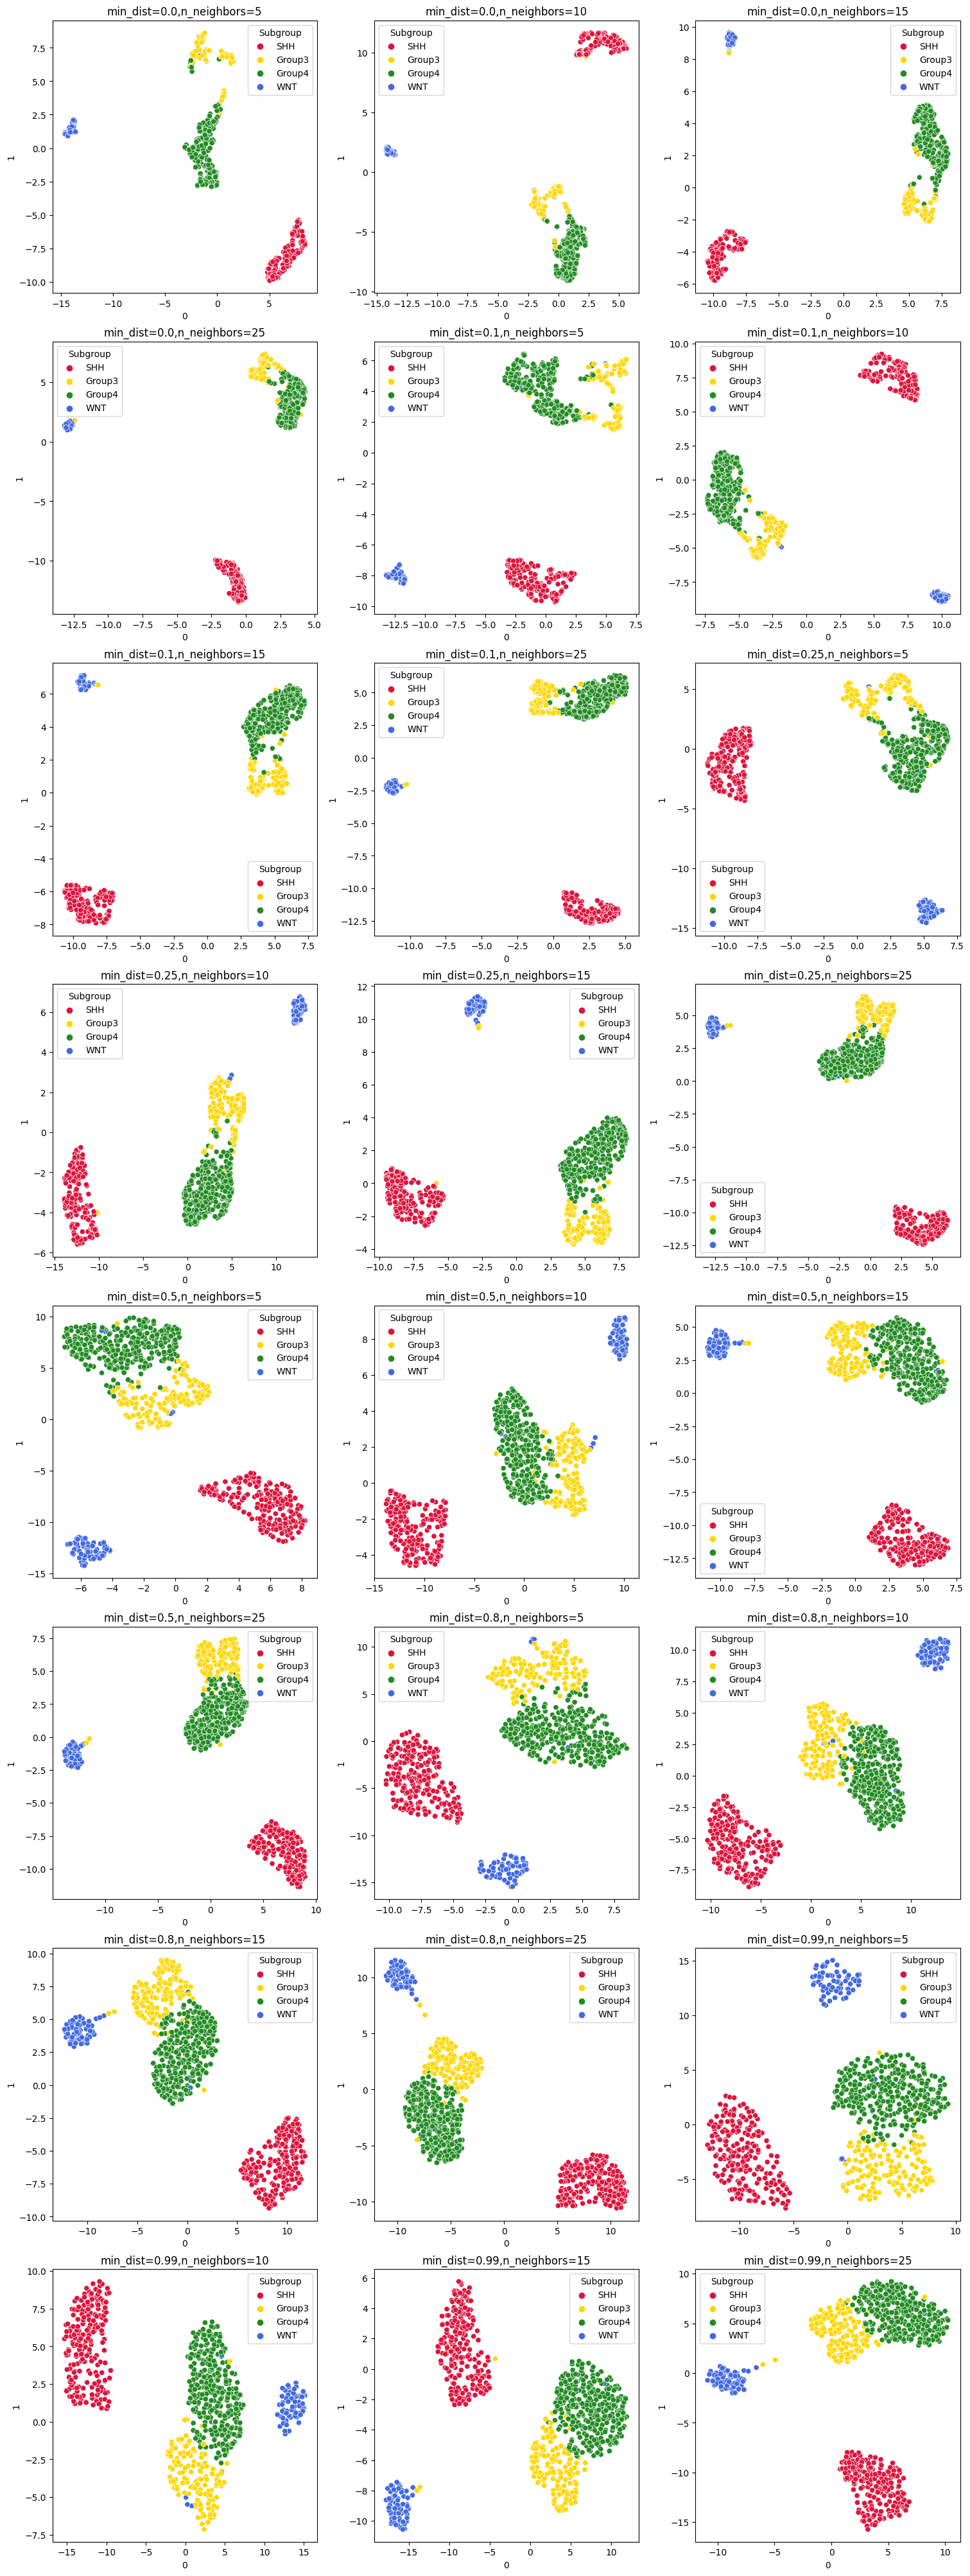

In [11]:
subgroup_umap=DimReduction()
subgroup_umap.plot_umap_parms(parms=parms_list,exp_mat=cp.transpose(data.exp_mat),metadata=data.meta,col_clusters="Subgroup",palette=pal_subgroup,main_title="")

## UMAP selected

In [13]:
def both_umap(exp_mat,metadata,parms={'min_dist': 0.5, 'n_neighbors': 25},n_rows=1,n_cols=2,size_subplot=(7,7),**kwargs):
    
    figsize= (size_subplot[0] * n_cols, size_subplot[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    umap=DimReduction()
    mat_embedded = umap.compute_umap_model_2D(exp_mat=exp_mat,inplace=False,**parms)
    mat_embedded.loc[metadata.index.to_list(),]
    
    subplot_title= ",".join(f"{key}={value}" for key, value in parms.items())
    umap.subplot_umap(ax=axes[0],mat_embedded=mat_embedded,palette=pal_subgroup,clusters=metadata["Subgroup"],title=subplot_title,**kwargs)
    umap.subplot_umap(ax=axes[1],mat_embedded=mat_embedded,palette=pal_subtype,clusters=metadata["Subtype"],title=subplot_title,**kwargs)
    
    plt.show()

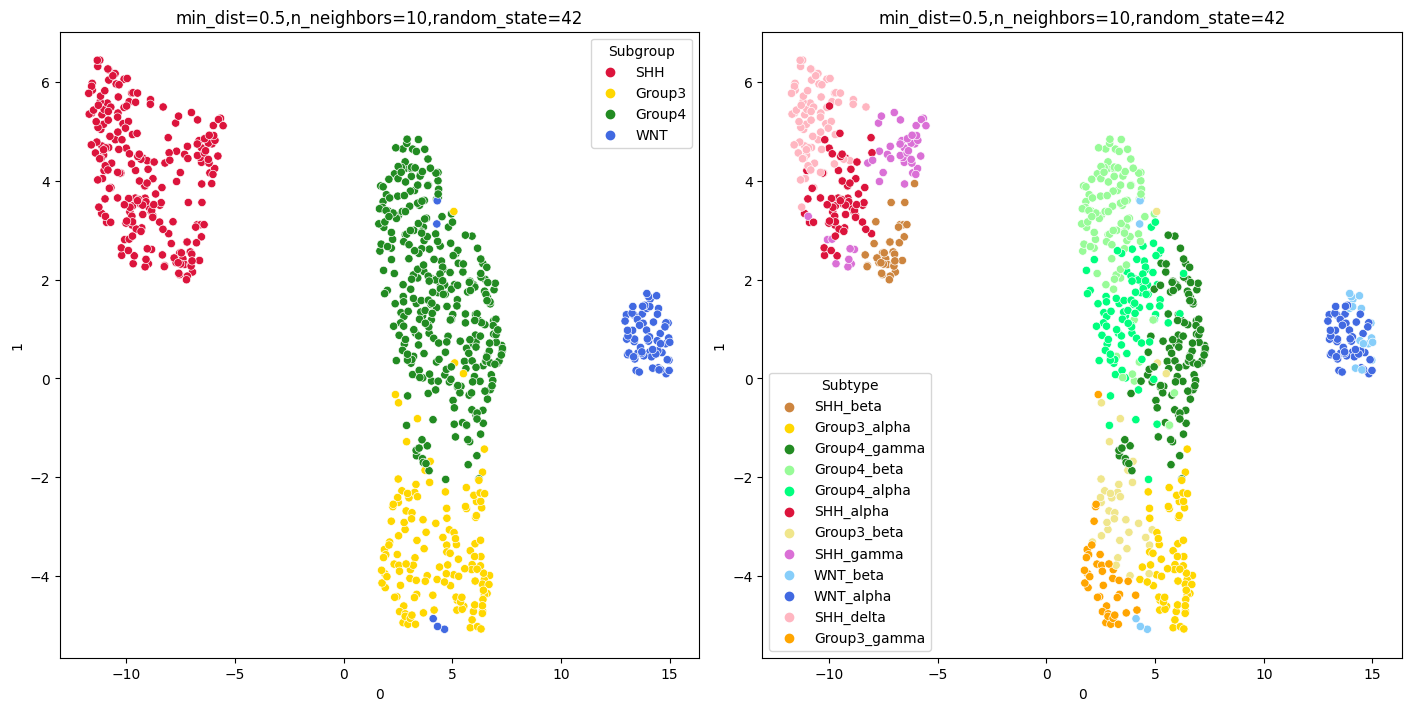

In [14]:
both_umap(exp_mat=cp.transpose(data.exp_mat),metadata=data.meta,parms={'min_dist': 0.5, 'n_neighbors': 10,'random_state':42})